In [2217]:
import autograd.numpy as np 
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb, _get_Cl_noise
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools.core as nd
import math as m
from fgbuster.algebra import  W_dBdB, W_dB, W, _mmm, _utmv, _mmv, comp_sep
import pylab as pl
import numdifftools
import numpy as np
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL 
from scipy.stats import norm

In [2218]:
nside = 64
model = 'd0s0'

In [2219]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

In [2220]:
d_fgs_N = get_observation(instrument, model, noise=True, nside=nside)
d_fgs = get_observation(instrument, model, noise=False, nside=nside)

#take only the Q and U, not I
freq_maps_N= d_fgs_N[:,1:,:]
freq_maps= d_fgs[:,1:,:]

n_freqs = freq_maps.shape[0]
n_stokes = freq_maps.shape[1]
n_pix = freq_maps.shape[2]


In [2221]:
components= [CMB(), Dust(150.), Synchrotron(150.)]

In [2222]:
M = MixingMatrix(*components) 
M_ev = M.evaluator(instrument.frequency)
M_dB_ev = M.diff_evaluator(instrument.frequency)
M_dB_dB_ev= M.diff_diff_evaluator(instrument.frequency)

In [2223]:
# N = np.diag((instrument.depth_p / hp.nside2resol(nside, arcmin=True))**2)
# invN = np.linalg.inv(N)

invN = np.linalg.inv(np.diag((instrument.depth_p / hp.nside2resol(nside, arcmin=True))**2))
N = np.zeros ((22,22))



In [2224]:
gains_true = np.ones(21)
x_true = np.concatenate((M.defaults, gains_true))
x_init = np.random.uniform(low=x_true * (1 - 1 / 4000000), high= x_true * (1 + 1 / 4000000 ))
n_sp = len(x_init[:-n_freqs+1])
n_channels= 22

In [2225]:
# dati = np.einsum('abc,cbx-> ax',freq_maps,freq_maps.T)


# def aver_likelihood(y):
#     Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
#     h = 1
#     G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
#     A =G.dot(M_ev(np.array([Bd,T,Bs]))) 
#     logL=0
#     NA= np.einsum('ab,bc->ac', invN,A)
#     AtNA = np.linalg.inv(np.einsum('ab,bc,cd->ad',A.T,invN,A))
#     AtN= np.einsum('ab,bc->ac', A.T, invN)
#     P = np.einsum ('ab,bc,cd->ad',NA,AtNA,AtN)
#     dN = dati+N
#     logL = logL - np.trace(np.einsum('ab,bc->ac',P,dN))/2
#     if logL != logL:
#         return 0.0
#     return logL

In [2226]:
dati = np.einsum('abc,cbx-> ax',freq_maps,freq_maps.T)


def aver_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
    h = n_channels - (a+b+c+d+e+f+g+i+l+m+n+o+p+q+r+s+t+u+v+w+z)
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A =G.dot(M_ev(np.array([Bd,T,Bs]))) 
    logL=0
    NA= np.einsum('ab,bc->ac', invN,A)
    AtNA = np.linalg.inv(np.einsum('ab,bc,cd->ad',A.T,invN,A))
    AtN= np.einsum('ab,bc->ac', A.T, invN)
    P = np.einsum ('ab,bc,cd->ad',NA,AtNA,AtN)
    dN = dati+N
    logL = logL - np.trace(np.einsum('ab,bc->ac',P,dN))/2
    if logL != logL:
        return 0.0
    return logL

In [2227]:
# def spec_likelihood(y):
#     Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
#     h = n_channels - (a+b+c+d+e+f+g+i+l+m+n+o+p+q+r+s+t+u+v+w+z)
#     G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z])
#     A =G.dot(M_ev(np.array([Bd,T,Bs]))) 
#     logL = 0
#     AinvNd= np.einsum('ba,ac,cde->bde', A.T, invN, freq_maps)
#     AtinvNA = np.linalg.inv(np.einsum('ab,bc,ce->ae',A.T,invN,A))
#     logL = logL + np.einsum('abc,cd,dba->', AinvNd.T, AtinvNA, AinvNd)
#     if logL != logL:
#         return 0.0
#     return logL

In [2228]:
c = UnbinnedNLL(x_init, aver_likelihood)

m = Minuit(aver_likelihood,x_init)
m.migrad()  # find minimum
m.hesse()   # compute uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.715e+10                 │              Nfcn = 878              │
│ EDM = 5.88e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.5400   │  0.0005   │            │            │         │         │       │
│ 1 │ x1   │   20.00   │   0.02    │            │            │         │         │       │
│ 2 │ x2   │  -3.000   │   0.004   │            │            │         │         │       │
│ 3 │ x3   │  1.0000   │  0.0019   │            │            │         │         │       │
│ 4 │ x4   │  1.0000   │  0.0011   │            │            │         │         │       │
│ 5 │ x5   │  1.0000   │  0.0007   │            │            │         │         │       │
│ 6 │ x6   │ 1000.0e-3 │  0.6e-3   │            │            │         │         │       │
│ 7 │ x7   │  1.0000   │  0.0009   │            │            │         │         │       │
│ 8 │ x8   │  1.0000   │  0.0006   │            │            │         │         │       │
│ 9 │ x9   │  1.0000   │  0.0007   │            │            │         │         │       │
│ 10│ x10  │  1.0000   │  0.0008   │            │            │         │         │       │
│ 11│ x11  │  1.0000   │  0.0004   │            │            │         │         │       │
│ 12│ x12  │1000.00e-3 │  0.28e-3  │            │            │         │         │       │
│ 13│ x13  │1000.00e-3 │  0.23e-3  │            │            │         │         │       │
│ 14│ x14  │  1.0000   │  0.0004   │            │            │         │         │       │
│ 15│ x15  │  1.00000  │  0.00027  │            │            │         │         │       │
│ 16│ x16  │  1.00000  │  0.00022  │            │            │         │         │       │
│ 17│ x17  │  1.00000  │  0.00019  │            │            │         │         │       │
│ 18│ x18  │  1.00000  │  0.00018  │            │            │         │         │       │
│ 19│ x19  │1000.00e-3 │  0.18e-3  │            │            │         │         │       │
│ 20│ x20  │  1.00000  │  0.00015  │            │            │         │         │       │
│ 21│ x21  │1000.00e-3 │  0.13e-3  │            │            │         │         │       │
│ 22│ x22  │  1.00000  │  0.00011  │            │            │         │         │       │
│ 23│ x23  │  1.00000  │  0.00015  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9       x10       x11       x12       x13       x14       x15       x16       x17       x18       x19       x20       x21       x22       x23 │
├─────┼─────────────────────────────────

In [2229]:
print(m.values[1:])

[19.99999925325213, -3.000000056600126, 0.999999900053018, 1.0000001480367102, 1.0000000479059934, 0.999999901542556, 1.0000002362613651, 1.0000000205564525, 1.000000123287745, 1.0000000534851614, 1.000000183782997, 0.9999998282241914, 0.9999999685048113, 1.0000002183225094, 1.0000001432124137, 1.0000001443937543, 1.0000000723801274, 1.0000001543530226, 0.9999999294755417, 1.0000000385956331, 0.9999999995525338, 1.0000001160550218, 1.0000001278532944]


In [2230]:
print(repr(m.covariance))

[[ 2.97623979e-07 -5.77376197e-06  1.69206402e-07  6.84656440e-08
   6.82329874e-09 -4.26536278e-08 -5.94121001e-08 -5.28732448e-08
  -5.54202398e-08 -5.41022646e-08 -2.88760010e-08 -1.00413119e-08
   2.06409039e-08  3.88075260e-08 -1.02068452e-08  2.05974869e-08
   3.88051532e-08  4.63507781e-08  4.40505700e-08  4.40417694e-08
   3.24601451e-08  1.56520640e-08 -4.95178668e-09 -2.37983687e-08]
 [-5.77376197e-06  4.18265237e-04  3.83234074e-06  1.71242984e-06
   5.64935158e-07 -4.44110594e-07 -9.24644244e-07 -7.95622729e-07
  -1.10506695e-06 -1.07754948e-06 -8.02387179e-07 -5.75619399e-07
   9.22721235e-09  5.00672403e-07 -5.79741404e-07  7.83970565e-09
   5.00514911e-07  8.80130285e-07  1.07266553e-06  1.07241215e-06
   1.05426284e-06  7.56844268e-07  8.35652536e-08 -9.80442598e-07]
 [ 1.69206402e-07  3.83234074e-06  1.95465594e-05  7.70822359e-06
   3.35176854e-06  4.82620037e-07 -7.85183694e-07 -8.08415016e-07
  -1.33159591e-06 -1.33228189e-06 -1.29848944e-06 -1.07123797e-06
  -6.954

In [2231]:
# #bnds = ((1.539, 1.541), (19.9, 20.1), (-3.001,-2.999), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.9,1.1), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001), (0.999,1.001))
# bnds = ((1.5, 1.6), (18, 22), (-4,-2), (0,2), (0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0,2))
# result= minimize(aver_likelihood, x_init, method='TNC', bounds=bnds)

# #tol = 1e-18
# print(result.x)



In [2232]:
# H = nd.Hessian(aver_likelihood)
# h = H(x_init) 

# sigma_params_square = np.linalg.inv(h)
# print(sigma_params_square.shape)


In [2233]:
def _G(gain_val_arr, n_freq,known_band):
    """
    Gain matrix G
    """
    assert len(gain_val_arr) == n_freq-1
    gain_all = list(gain_val_arr)[:known_band]+[n_freq-np.sum(gain_val_arr)]+list(gain_val_arr)[known_band:] 
    
    return np.diag(gain_all)

G= _G(m.values[3:], n_freq=n_freqs, known_band=0)
print(G.shape)
print(G)

(22, 22)
[[0.99999864 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.00000015 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.00000005 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.9999999  0.
  0.         0.        

In [2234]:
def _G_dB(gain_params, n_freq, known_band):
    # this is mainly made of zeros
    G_dB = np.zeros([len(gain_params), n_freq, n_freq])
    for gi, _ in enumerate(gain_params):
        if gi >= known_band:
            fi = gi + 1
        else:
            fi = gi
        G_dB[gi, fi, fi] = 1
        G_dB[gi, known_band, known_band] = -1
    
    return G_dB

G_dB=_G_dB(m.values[3:], n_freq=n_freqs, known_band=0)
print(_G_dB(m.values[3:], n_freq=n_freqs, known_band=0).shape)
print(_G_dB(m.values[3:], n_freq=n_freqs, known_band=0))

(21, 22, 22)
[[[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  1.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  1. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  1.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  1.  0.]
  [ 0.  0.  0. 

In [2235]:
def A_ev(x):
        x_sp = x[:n_sp]
        x_gain = x[n_sp:]
        M_x = M_ev(x_sp)
        G_x = _G(x_gain, n_freqs, known_band=0)
        return np.einsum('fe, ...ec -> ...fc', G_x, M_x)

A_maxL = A_ev(m.values)
print(A_maxL.shape)

(22, 3)


In [2236]:
AtN=A_maxL.T.dot(invN)
AtNA=np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))

comp_maps=np.einsum ('cg,gs,sij->cij', AtNA,AtN, freq_maps)

residual_maps_QU = comp_maps[0]
zeros=np.zeros((1, 49152))
residual_maps_IQU = np.vstack((zeros, residual_maps_QU))

In [2237]:
# #multipole range 
lmin= 2
lmax= 2*nside-1
ell = np.arange(lmin,lmax+1)


# #power spectrum of the total residual 
# Cl_BB_residual =hp.anafast(residual_maps_IQU)[2,lmin:lmax+1] #with [2] I select the B mode #closed to bias
# Dl_BB_residual = (ell*(ell+1)*Cl_BB_residual)/(2*m.pi)


# #Cl theory 
Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][lmin:lmax+1]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2] [lmin:lmax+1]

# #Dl theory
# Dl_BB_r001 = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)


# #lensing
# Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][lmin:lmax+1]
# Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

# #plot power spectra
# plt.loglog(ell, Dl_BB_residual, label = "Dl_BB_residual")
# plt.loglog(ell, Dl_lens, label = "Dl_lensing")
# plt.loglog(ell, Dl_BB_r001, label = "Dl_BB_r0.001")
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
# plt.legend()

In [2238]:
# Data = Cl_BB_residual + Cl_lens #it is needed by the cosmological likelihood
fsky = 1
# F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2) #it is a scalar because I am using comsological likelihood
# sigma_r_fisher = np.sqrt(1.0 / F)

In [2239]:
i_cmb = M.components.index('CMB')
W_maxL = np.einsum ('cg,gs->cs', AtNA,AtN)[i_cmb,:]
print(W_maxL)

[-0.03041548 -0.01610324 -0.01567065 -0.00607397 -0.00238701  0.00446021
  0.00294775  0.02191577  0.00399276  0.04330986  0.09867326  0.12125213
  0.06439263  0.17959846  0.15565565  0.20583406  0.11846322  0.05325374
  0.03602742  0.00161806 -0.02199438 -0.01875037]


In [2240]:
def _G_M_dB(G,M_dB):
    return np.einsum('fe, p...ec -> p...cf', G, M_dB)

def _G_dB_M(G_dB, M):
    return np.einsum('pef, ...ec -> p...cf', G_dB, M)

def _G_dB_M_dB (G_dB,M_dB):
    return np.einsum('gef, pec -> gpcf', G_dB, M_dB)

def _M_dB_G_dB (M_dB,G_dB):
    return np.einsum('pec, gef -> pgcf', M_dB, G_dB)

In [2241]:
def A_dB_ev(x):
    x_sp = x[:n_sp]
    x_gain = x[n_sp:]

    M_x = M_ev(x_sp)
    G_x = _G(x_gain, n_freqs, known_band=0)
 

    G_dB_x = _G_dB(x_gain, n_freqs, known_band=0)
    G_dB_M_x = _G_dB_M(G_dB_x, M_x)

    zeros=np.zeros((3,22,2))
    M_dB_x= np.concatenate((M_dB_ev(x_sp),zeros), axis=2)
    G_M_dB_x = _G_M_dB(G_x, M_dB_x)
    
    print(G_dB_M_x.shape)
    print(G_M_dB_x.shape)
    
    A_dB= np.concatenate((G_M_dB_x,G_dB_M_x), axis=0)
    return A_dB

A_dB_maxL = A_dB_ev(m.values)
print(A_dB_maxL.shape)
print(A_dB_maxL)

(21, 3, 22)
(3, 3, 22)
(24, 3, 22)
[[[-1.18924062e-01 -1.40894654e-01 -1.58070501e-01 ...  4.45803281e+00
    1.35389149e+01  4.38323792e+01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-6.38749665e-04 -8.30758129e-04 -1.00944529e-03 ...  6.51905204e-02
    2.23713764e-01  8.18003348e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-4.18676431e+01 -1.82320846e+01 -9.04971911e+00 ...  3.10481765e-01
    4.39002209e-01  6.97816595e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00

In [2242]:
def A_dB_dB_ev(x):
    x_sp = x[:n_sp]
    x_gain = x[n_sp:]
    G_dB = _G_dB(x_gain, n_freqs, known_band=0)
    
    zeros=np.zeros((3,22,2))
    M_dB= np.concatenate((M_dB_ev(x_sp),zeros), axis=2)
    zeros_1=np.zeros((21,22,3))
    M_dB_x= np.concatenate((M_dB,zeros_1), axis=0)

    zeros_2=np.zeros((3,22,22))
    G_dB_x=np.concatenate((G_dB,zeros_2), axis=0)


    M_dB_G_dB_x= _M_dB_G_dB (M_dB_x,G_dB_x)
    G_dB_M_dB_x=_G_dB_M_dB (G_dB_x,M_dB_x)



    M_dB_dB_x = M_dB_dB_ev(x_sp)
    M_dB_dB_x=np.array(M_dB_dB_x)

    M_dB_dB_all = np.zeros((24,24,3,22))
    M_dB_dB_all[0,0,0]= M_dB_dB_x[0,0][:,0]
    M_dB_dB_all[0,1,1]= M_dB_dB_x[0,1][:,0]
    M_dB_dB_all[1,1,0]= M_dB_dB_x[1,0][:,0]
    M_dB_dB_all[1,1,1]= M_dB_dB_x[1,1][:,0]
    M_dB_dB_all[2,2,2]= M_dB_dB_x[2,1][:,0]

     
    A_dB_dB= G_dB_M_dB_x + M_dB_G_dB_x + M_dB_dB_all 
    print(A_dB_dB)

    return A_dB_dB

A_dB_dB_maxL = A_dB_dB_ev(m.values)


[[[[ 3.95037233e-01 -1.27000723e-01  1.44838514e-01 ...  2.78250039e+00
     1.09590414e+01  4.32106900e+01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 1.19562974e-01 -8.30758212e-04 -1.58070478e-01 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 8.44272245e-04  9.12681180e-04  9.24945230e-04 ...  4.06889442e-02
     1.81084556e-01  8.06401335e-01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 4.19866241e+01 -1.82320864e+01  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  ...

  [[ 0

/var/folders/_1/19g0k8_x0fz75zc8hlsy_0fh0000gn/T/ipykernel_89041/2725372249.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  M_dB_dB_x=np.array(M_dB_dB_x)


In [2243]:
#W_dB_maxL

a = -np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL)) #(3,3)
b = np.einsum('fcg, fx, xs-> cgs',A_dB_maxL.T, invN, A_maxL)+ np.einsum('cf, fx, gsx-> cgs',A_maxL.T, invN, A_dB_maxL)
#(3,24,3)
c = np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL))#(3,3)
d = np.einsum('fcg, fx-> cgx',A_dB_maxL.T, invN)#(3,24,22)
e = np.einsum( 'cf, fx-> cx', A_maxL.T, invN)#(3,22)
f = np.einsum ( 'ab, bcd-> acd', a,b)
g = np.einsum ( 'ab, bc-> ac', c,e)


W_dB_maxL = np.einsum('abc, cd-> bad', f,g) + np.einsum('cx, xgf-> gcf', c, d)  #(params_tot,component,freq)=(24,3,22)
print(W_dB_maxL)
W_dB_maxL = W_dB_maxL [:, i_cmb]

[[[-4.04510470e-02 -1.99751259e-02 -1.63295727e-02 ... -4.79096739e-02
   -3.37081496e-02 -1.94959219e-05]
  [ 2.86947496e-02  1.50149933e-02  1.42293831e-02 ...  4.62868259e-03
    2.12980351e-02  1.46259103e-02]
  [ 3.96859510e-03  1.84532061e-03  1.24395644e-03 ...  8.67406743e-03
    3.66081923e-03 -1.97595590e-03]]

 [[-8.01523618e-04 -3.95345450e-04 -3.19608996e-04 ... -1.39968174e-03
   -8.36994264e-04  1.97624137e-04]
  [ 5.08493983e-04  2.65650734e-04  2.50508212e-04 ...  1.50285921e-04
    3.99354294e-04  2.28422101e-04]
  [ 9.15843035e-05  4.33388652e-05  3.06174975e-05 ...  2.51118478e-04
    1.11909926e-04 -6.63147120e-05]]

 [[ 8.00083794e-03  2.42134750e-02  4.81280748e-02 ... -1.41597386e-02
    4.00270655e-02  3.65708899e-02]
  [ 3.12814278e-03 -8.00111361e-04 -3.79895272e-03 ...  1.52223011e-03
   -1.94800868e-03 -1.96162083e-03]
  [-2.96158317e-02 -1.92255807e-02 -2.30690448e-02 ...  4.01311584e-03
   -2.74934725e-02 -2.38727850e-02]]

 ...

 [[-7.52945986e-04 -1.933

In [2244]:
#W_dB_dB_maxL

h = np.einsum ( 'bacd,be,ef->cdaf', A_dB_dB_maxL.T, invN, A_maxL )
i = np.einsum ( 'bac,bd,efd->ceaf', A_dB_maxL.T, invN, A_dB_maxL )
l = np.einsum ( 'ab,bc,defc->deaf', A_maxL.T,invN, A_dB_dB_maxL)

print(h.shape)
print(i.shape)
print(l.shape)


p = h+i+i+l
o = np.einsum (  'ab,bc,cd->ad', a,c,e)


H = np.einsum('ab,bcd,de,efg,gh,hi->cfai', a,b,c,b,c,e)
B =  np.einsum ( 'ab,cdea->cdeb',o,p)
C = np.einsum('ab,bcd,de,fg,ghi,if->chae', a,b,e,a,b,c)
D = np.einsum('ab,bcd,de,efg->cfag', a,b,c,d)
E = np.einsum ('ab,cbde,cf->deaf', c,A_dB_dB_maxL.T,invN)


W_dB_dB_maxL = - H + B + C + D + D + E
print(W_dB_dB_maxL)
W_dB_dB_maxL =  W_dB_dB_maxL[:, :, i_cmb]

(24, 24, 3, 3)
(24, 24, 3, 3)
(24, 24, 3, 3)
[[[[ 3.33823225e-01  1.51596108e-01  7.30644760e-02 ... -1.08257201e+01
    -9.46113972e+00 -5.13283937e+00]
   [ 5.08210636e-01  2.67079088e-01  2.56501673e-01 ...  1.11911294e+00
     1.34136549e+00  8.06313334e-01]
   [ 1.07477680e-01  6.38176348e-02  8.15742964e-02 ...  1.95001991e+00
     1.82974124e+00  1.03303418e+00]]

  [[ 6.52973599e-03  2.62894224e-03 -2.04220466e-03 ... -2.05369058e-01
    -1.80433258e-01 -9.78552109e-02]
   [ 5.00857516e-04  2.04499429e-04  3.52948836e-04 ...  2.21022177e-02
     1.93028455e-02  9.53917070e-03]
   [ 1.15357448e-03  7.98433549e-04  1.69749637e-03 ...  3.68607146e-02
     3.42003858e-02  1.91994535e-02]]

  [[-1.89434845e-01 -3.18952985e-01 -4.66685278e-02 ...  1.70222852e+01
     1.58274995e+01  9.02098188e+00]
   [ 2.49616874e-01  1.59217127e-01  1.64951147e-01 ... -1.96544639e+00
    -1.93205493e+00 -1.12815796e+00]
   [ 2.13758084e-01  1.53370835e-01  1.00356651e-01 ... -3.03614273e+00
    -2.

In [2245]:
if n_stokes == 3:  
    d_spectra = freq_maps
else:  # Only P is provided, add T for map2alm
    d_spectra = np.zeros((n_freqs, 3, freq_maps.shape[2]), dtype=freq_maps.dtype)
    d_spectra[:, 1:] = freq_maps

# Compute cross-spectra
almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=freq_maps.dtype)
for f1 in range(n_freqs):
    for f2 in range(n_freqs):
        if f1 > f2:
            Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
        else:
            Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

Cl_fgs = Cl_fgs[..., lmin:] / fsky

In [2246]:

V_maxL = np.einsum('ij,ij...->...',  m.covariance, W_dB_dB_maxL)


# Check dimentions
assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]== W_dB_dB_maxL.shape[2:] == V_maxL.shape)
assert (len(m.values) == W_dB_maxL.shape[0] == W_dB_dB_maxL.shape[0] == W_dB_dB_maxL.shape[1])

# elementary quantities defined in Stompor, Errard, Poletti (2016)
Cl_xF = {}
Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)= (191)
Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)=(191,24,24)
Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)



Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[ i_cmb,  i_cmb, lmin:]

# bias and statistical foregrounds residuals
noise = Cl_noise
bias = Cl_xF['yy'] + 2 * Cl_xF['yz']
stat = np.einsum('ij, lij -> l',  m.covariance, Cl_xF['YY'])  
var = stat**2 + 2 * np.einsum('li, ij, lj -> l', Cl_xF['Yy'],  m.covariance, Cl_xF['Yy'])

print(bias)



[1.07462898e-09 1.00382665e-08 1.01825469e-09 2.08123721e-09
 7.95159373e-10 9.98142332e-10 4.48724420e-10 4.00252271e-10
 3.57642607e-10 1.95799872e-10 1.69679425e-10 1.53902912e-10
 1.79430107e-10 9.02504336e-11 1.19590802e-10 8.37461076e-11
 1.27485940e-10 5.91342922e-11 8.69907706e-11 5.29482556e-11
 5.86826607e-11 5.64230505e-11 4.37614034e-11 6.15229853e-11
 4.07087032e-11 4.62502130e-11 2.94636073e-11 3.91238145e-11
 2.89631343e-11 3.40405127e-11 2.76095182e-11 2.71050517e-11
 2.20070509e-11 1.89071197e-11 1.99829405e-11 1.71554752e-11
 1.46481547e-11 2.12783184e-11 1.43130100e-11 2.06328025e-11
 1.07415000e-11 1.39974432e-11 1.29629100e-11 1.01608245e-11
 9.12941777e-12 9.48329567e-12 1.03003999e-11 7.09525536e-12
 9.07562873e-12 6.76139605e-12 7.86975765e-12 8.47256932e-12
 8.00125915e-12 5.52063808e-12 5.77967778e-12 4.38257962e-12
 4.71432337e-12 3.71344958e-12 4.60804051e-12 3.32279125e-12
 4.49441930e-12 3.69637480e-12 4.04597647e-12 3.18488446e-12
 3.15504107e-12 3.717437

(2, 127)

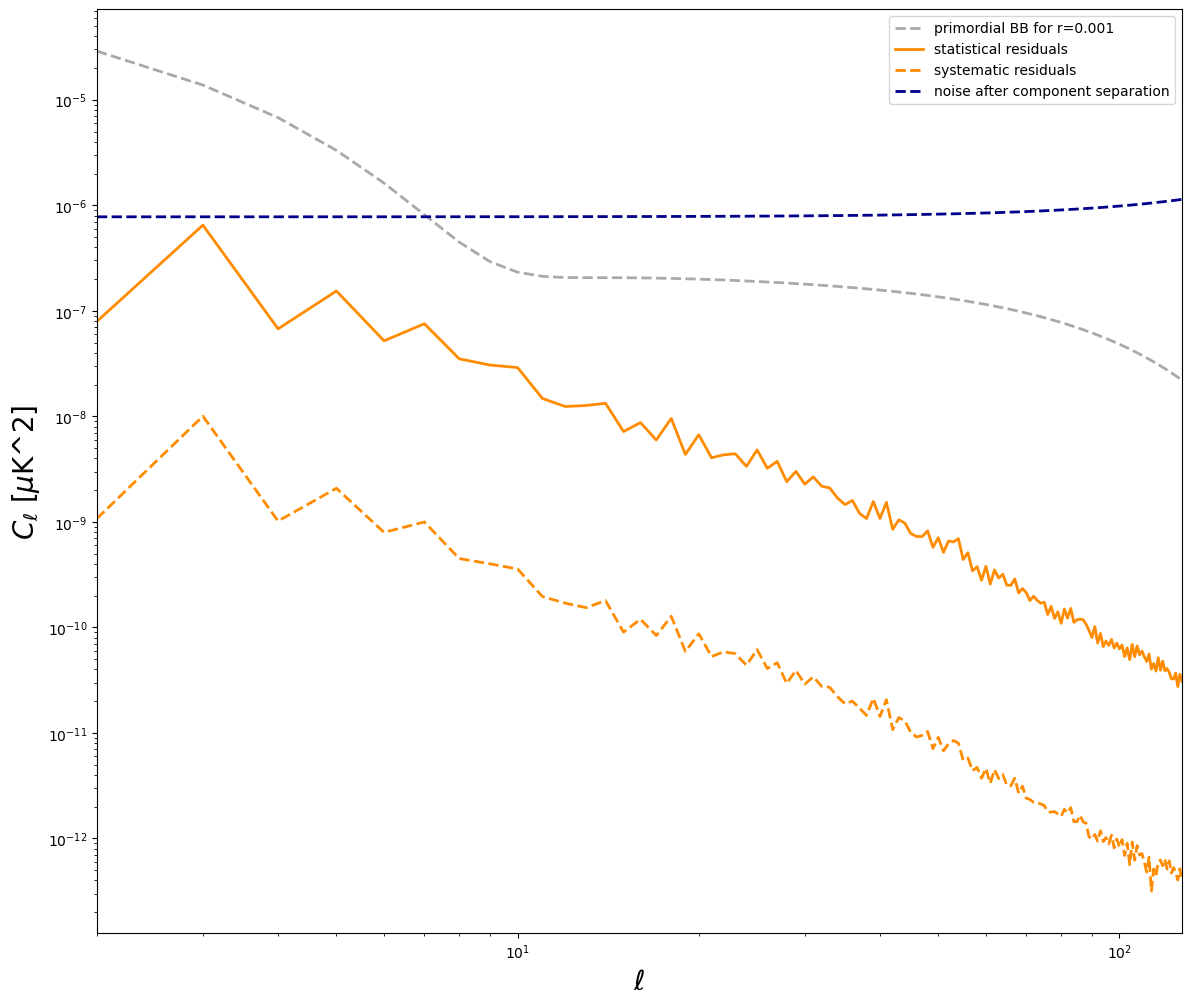

In [2247]:
lmin= 2
lmax= 127
ell = np.arange(lmin, lmax+1)


Cl_fid = {}
Cl_fid['BB'] = _get_Cl_cmb(Alens=0.1, r=0.001)[2][lmin:lmax+1]
Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]



fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
ax = pl.gca()
left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]

# ax.loglog(ell, Cl_BB_r_001, color='DarkGray', linestyle='-', label='BB tot', linewidth=2.0)
ax.loglog(ell, Cl_BB_r_001 , color='DarkGray', linestyle='--', label='primordial BB for r='+str(0.001), linewidth=2.0)
ax.loglog(ell, stat, 'DarkOrange', label='statistical residuals', linewidth=2.0)
ax.loglog(ell, bias, 'DarkOrange', linestyle='--', label='systematic residuals', linewidth=2.0)
ax.loglog(ell, noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)
# ax.loglog(ell, Cl_BB_residual, 'DarkGreen', linestyle='--', label='residual', linewidth=1.0)
ax.legend()
ax.set_xlabel('$\ell$', fontsize=20)
ax.set_ylabel('$C_\ell$ [$\mu$K^2]', fontsize=20)
ax.set_xlim(lmin,lmax)

[2.93141534e-08 2.58700245e-07 2.85615285e-08 5.52891863e-08
 2.14159844e-08 2.69217721e-08 1.26162896e-08 1.12393471e-08
 1.00502402e-08 5.61710876e-09 4.65379932e-09 4.59079015e-09
 4.86815854e-09 2.69848733e-09 3.31796891e-09 2.36305057e-09
 3.50868406e-09 1.67563858e-09 2.43178947e-09 1.48779586e-09
 1.61576281e-09 1.60605850e-09 1.25415768e-09 1.70631871e-09
 1.16174961e-09 1.30600940e-09 8.68917570e-10 1.06451333e-09
 8.12461510e-10 9.30452029e-10 7.80263475e-10 7.33786612e-10
 5.95553584e-10 5.22270166e-10 5.56860614e-10 4.36049417e-10
 3.87403681e-10 5.55313013e-10 3.77588924e-10 5.39788977e-10
 3.06036900e-10 3.62031254e-10 3.44908241e-10 2.69911329e-10
 2.54365433e-10 2.57542086e-10 2.91484756e-10 1.99847466e-10
 2.50576926e-10 1.77220106e-10 2.31151409e-10 2.23661358e-10
 2.37678097e-10 1.58815107e-10 1.74056022e-10 1.23471553e-10
 1.30520787e-10 1.01063888e-10 1.32471767e-10 9.24994145e-11
 1.21869658e-10 1.02809096e-10 1.12502095e-10 8.66044398e-11
 8.78688602e-11 9.760384

(2, 127)

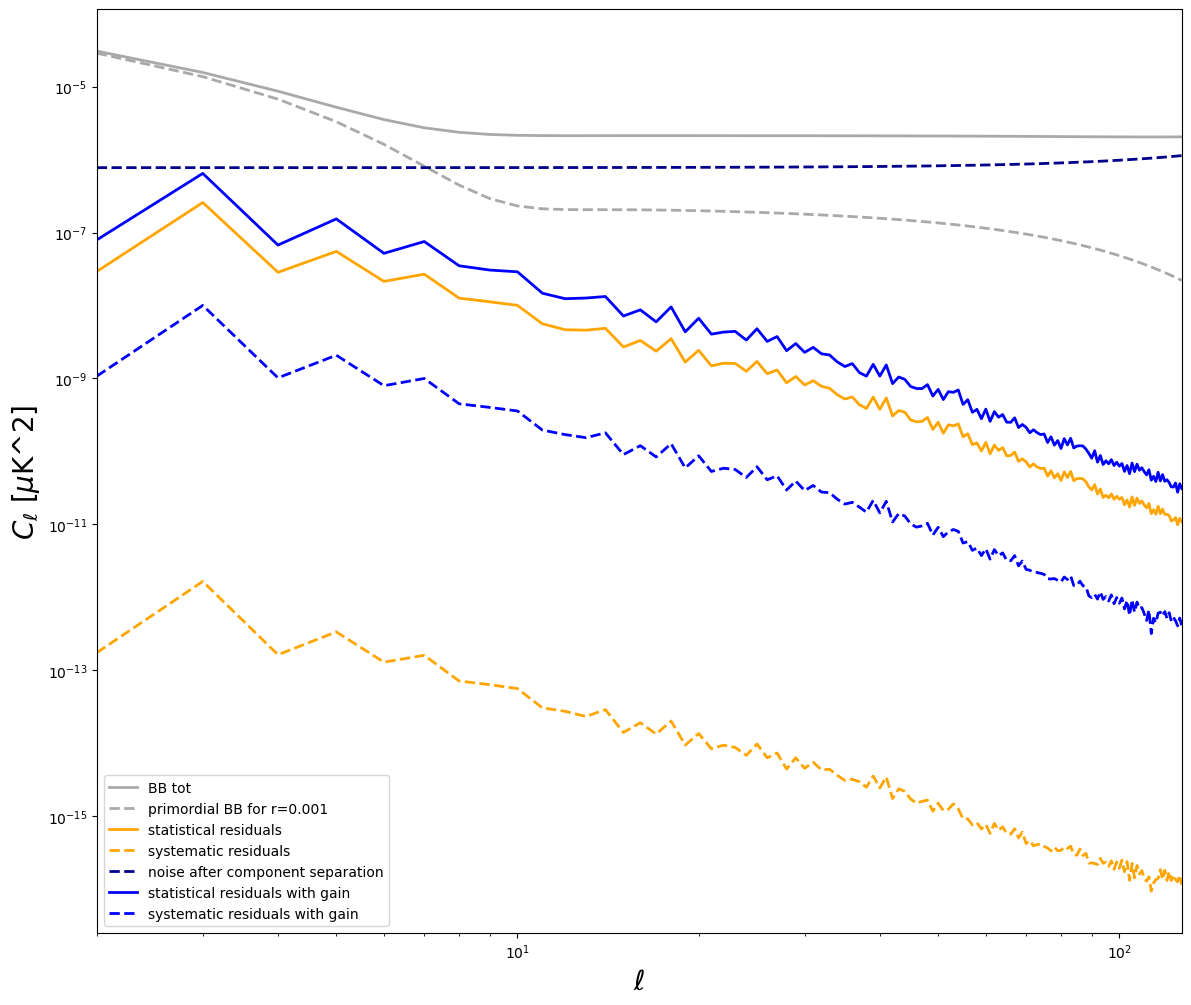

In [2248]:
#FORECAST WITHOUT GAIN
d_fgs=freq_maps
instrument = standardize_instrument(instrument)
nside = hp.npix2nside(d_fgs.shape[-1])
n_stokes = d_fgs.shape[1]
n_freqs = d_fgs.shape[0]
invN = np.diag(hp.nside2resol(nside, arcmin=True) / (instrument.depth_p))**2
mask = d_fgs[0, 0, :] != 0.
fsky = mask.astype(float).sum() / mask.size
ell = np.arange(lmin, lmax+1)
    

############################################################################
# 1. Component separation using the noise-free foregrounds templare
# grab the max-L spectra parameters with the associated error bars
   
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
A_dB_ev = A.diff_evaluator(instrument.frequency)

x0 = np.array([x for c in components for x in c.defaults])
if n_stokes == 3:  # if T and P were provided, extract P
    d_comp_sep = d_fgs[:, 1:, :]
else:
    d_comp_sep = d_fgs

res = comp_sep(A_ev, d_comp_sep.T, invN, A_dB_ev, A.comp_of_dB, x0)

res.params = A.params
res.s = res.s.T
A_maxL = A_ev(res.x) 
A_dB_maxL = A_dB_ev(res.x)
A_dBdB_maxL = A.diff_diff_evaluator(instrument.frequency)(res.x)


############################################################################
# 2. Estimate noise after component separation
### A^T N_ell^-1 A
   
i_cmb = A.components.index('CMB')
Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[i_cmb, i_cmb, lmin:]


############################################################################
# 3. Compute spectra of the input foregrounds maps
### TO DO: which size for Cl_fgs??? N_spec != 1 ? 

if n_stokes == 3:  
    d_spectra = d_fgs
else:  # Only P is provided, add T for map2alm
    d_spectra = np.zeros((n_freqs, 3, d_fgs.shape[2]), dtype=d_fgs.dtype)
    d_spectra[:, 1:] = d_fgs

# Compute cross-spectra
almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=d_fgs.dtype)
for f1 in range(n_freqs):
    for f2 in range(n_freqs):
        if f1 > f2:
            Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
        else:
            Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

Cl_fgs = Cl_fgs[..., lmin:] / fsky

############################################################################
# 4. Estimate the statistical and systematic foregrounds residuals
  
W_maxL = W(A_maxL, invN=invN)[i_cmb, :]
W_dB_maxL = W_dB(A_maxL, A_dB_maxL, A.comp_of_dB, invN=invN)[:, i_cmb]
W_dBdB_maxL = W_dBdB(A_maxL, A_dB_maxL, A_dBdB_maxL,A.comp_of_dB, invN=invN)[:, :, i_cmb]

   
V_maxL = np.einsum('ij,ij...->...', res.Sigma, W_dBdB_maxL)
    

# Check dimentions
assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]
                    == W_dBdB_maxL.shape[2:] == V_maxL.shape)
assert (len(res.params) == W_dB_maxL.shape[0] 
                        == W_dBdB_maxL.shape[0] == W_dBdB_maxL.shape[1])

# elementary quantities defined in Stompor, Errard, Poletti (2016)
Cl_xF = {}
Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)


# bias and statistical foregrounds residuals
res.noise = Cl_noise
res.bias = Cl_xF['yy'] + 2 * Cl_xF['yz']  # S16, Eq 23
res.stat = np.einsum('ij, lij -> l', res.Sigma, Cl_xF['YY'])  # E11, Eq. 12
res.var = res.stat**2 + 2 * np.einsum('li, ij, lj -> l', # S16, Eq. 28
                                        Cl_xF['Yy'], res.Sigma, Cl_xF['Yy'])

print(res.stat)

Alens=1.0 
r=0.001   

Cl_fid = {}
Cl_fid['BB'] = _get_Cl_cmb(Alens=Alens, r=r)[2][lmin:lmax+1]
Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]

res.BB = Cl_fid['BB']*1.0
res.BuBu = Cl_fid['BuBu']*1.0
res.BlBl = Cl_fid['BlBl']*1.0
res.ell = ell

fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
ax = pl.gca()


ax.loglog(ell, Cl_fid['BB'], color='DarkGrey', linestyle='-', label='BB tot', linewidth=2.0)
ax.loglog(ell, Cl_fid['BuBu']*r , color='DarkGrey', linestyle='--', label='primordial BB for r='+str(r), linewidth=2.0)
ax.loglog(ell, res.stat, 'Orange', label='statistical residuals', linewidth=2.0)
ax.loglog(ell, res.bias, 'Orange', linestyle='--', label='systematic residuals', linewidth=2.0)
ax.loglog(ell, res.noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)

#compare with gain
ax.loglog(ell, stat, 'Blue', label='statistical residuals with gain', linewidth=2.0)
ax.loglog(ell, bias, 'Blue', linestyle='--', label='systematic residuals with gain', linewidth=2.0)

ax.legend()
ax.set_xlabel('$\ell$', fontsize=20)
ax.set_ylabel('$C_\ell$ [$\mu$K^2]', fontsize=20)
ax.set_xlim(lmin,lmax)
